# Vehicle Detection

In this project I'll write a software pipeline to detect vehicles in a video.

## Goals of Project

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# Data Exploration

There are two videos given first one `test_video.mp4` which can be used to test pipeline. Second one `project_video.mp4` is the video on which will be evaluated and pipeline should be able to detect vehicles reliably on that video.

Training images are split into **vehicle** and **non-vehicle** classes.

<figure>
 <img src="./illustrations/vehicle_01.png" width="64" alt="Vehicle 01" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Example of Vehicle</p> 
 </figcaption>
</figure>

<figure>
 <img src="./illustrations/vehicle_02.png" width="64" alt="Vehicle 02" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Example of Another Vehicle</p> 
 </figcaption>
</figure>

<figure>
 <img src="./illustrations/non_vehicle_01.png" width="64" alt="Non Vehicle 01" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Example of Non Vehicle</p> 
 </figcaption>
</figure>

<figure>
 <img src="./illustrations/non_vehicle_02.png" width="64" alt="Non Vehicle 02" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Example of Another Non Vehicle</p> 
 </figcaption>
</figure>




### Load Data

I have created a helpful script which downloads data from internet and unpacks it into `./data` directory

Next we need a way to load training images in python. My plan is to create 2 functions for loading training data. First one loads small subset of data and the second one loads the full set. Both of those functions should return data in same format and in this case let's define that the format should be **uint8 BGR** which is easy to use with OpenCV2.

in `dataset.py` i have created 2 functions `load_small()` and `load_full()` which are loading the small and full datasets respectively.
Those functions return features and labels and in this case feature is array of (N, 64, 64, 3) where **N** denotes the number of images. labels are simply **number 0 for non-vehicles** and **number 1 for vehicles**.



### Statistics

Let's briefly check quantity, shape and type of data.

In [1]:
import dataset

dataset.print_statistics()

Small data set:
	Number of vehicle images is 1196
	Number of non-vehicle images is 1125
	Shape of the image is  (64, 64, 3)
	Datatype of image is  uint8


Full data set:
	Number of vehicle images is 8792
	Number of non-vehicle images is 8968
	Shape of the image is  (64, 64, 3)
	Datatype of image is  uint8


# Feature Selection

Ideally we should find features which are small in dimensions and yet differentiate classes from each other well. I.e. We need to differentiate cars from pedestrians. 

In our case images are size of (64,64,3), colorspace is RGB and dataformat is uint8. That makes roughly 12kb per image.

I'll focus on following features: **Spatial**, **color** and **Histogram of Oriented Gradient(HOG)**

Let's first check what color space we should use, because that is one of the most important features if not the most important. I made a helpfull script `feature_selection.py` to do a "grid search" on features. This script turn out to be really useful on selecting suitable features. Ok. so first i run search for color space.
Purpose of this first search is to find best color plane to use. 

Other parameters I kept near the defaults in order to save time. I'm going to tune those after finding the best color plane.
```
HOG Orientation Bins = 9
HOG Pixels per cell = 16, 16
HOG cells per block = 4, 4
HOG channels = (0, 1, 2)
spatial size = (16,16)
Color Histogram Channels = (0, 1, 2)
hog_feat=True
hist_feat=True
spatial_Feat=True
Classifier: Linear SVM, C=50
Training samples: 8880 
Test samples: 8880
```

I performed 3-fold stratified cross validation  and results show that LUV, YCrCb, YUV and LAB are all performing almost equally well. All of them got best score above 98,1%. Data set is split into half, 50% for training and 50% for testing. Reason why i did this kind of split is that with these ratios training time is still manageable. If training set size would be more than 10k then training time would be much longer as it grows exponentially.

| Rank | Tot. Test Time | Time / Sample | Score  | Vector Length | Colorspace    | Hist. Bins | 
|------|----------------|---------------|--------|---------------|---------------|------------| 
| 1    | 15             | 0.00169       | 0.9815 | 1968          | LUV           | 256        | 
| 2    | 15.1           | 0.0017        | 0.9815 | 1968          | YCrCb         | 256        | 
| 3    | 14.8           | 0.00167       | 0.9815 | 1968          | HSV           | 256        | 
| 4    | 16.3           | 0.00183       | 0.9815 | 1968          | BGR           | 256        | 
| 5    | 15.8           | 0.00178       | 0.9815 | 1968          | LAB           | 256        | 
| 6    | 12.9           | 0.00145       | 0.9808 | 1788          | LUV           | 196        | 
| 7    | 13             | 0.00146       | 0.9808 | 1788          | YCrCb         | 196        | 
| 8    | 12.7           | 0.00143       | 0.9808 | 1788          | HSV           | 196        | 
| 9    | 14             | 0.00157       | 0.9808 | 1788          | BGR           | 196        | 
| 10   | 13.8           | 0.00155       | 0.9808 | 1788          | LAB           | 196        | 



From these colorspaces I select LUV color space for further  studies. After finding out reasonable values for other tunable parameters i can come back to color space selection and see whether there are some changes needed.


## Spatial Features

As our guest for best features continues i noticed surprisingly that larger spatial feature size doesn't necessarily mean better prediction accuracy.

```
Color Histogram Channels = (0, 1, 2)
Color Histogram Bins = 128
hog_feat=False
hist_feat=True
spatial_Feat=True
Classifier: Linear SVM, C=50
Training samples: 8880 
Test samples: 8880
```


First iteration yield following results.

| Rank | Tot. Test Time | Time / Sample | score  | Vector Length | Colorspace | Binning  | 
|------|----------------|---------------|--------|---------------|------------|----------| 
| 1    | 10.9           | 1.23E-03      | 0.9570 | 1251          | LUV        | (17, 17) | 
| 2    | 10.7           | 1.21E-03      | 0.9570 | 1251          | YCrCb      | (17, 17) | 
| 3    | 10.6           | 1.20E-03      | 0.9570 | 1251          | HSV        | (17, 17) | 
| 4    | 10.7           | 1.21E-03      | 0.9570 | 1251          | BGR        | (17, 17) | 
| 5    | 10.7           | 1.20E-03      | 0.9570 | 1251          | LAB        | (17, 17) | 
| 6    | 12.2           | 1.38E-03      | 0.9567 | 1356          | LUV        | (18, 18) | 
| 7    | 12.5           | 1.41E-03      | 0.9567 | 1356          | YCrCb      | (18, 18) | 
| 8    | 13.9           | 1.56E-03      | 0.9567 | 1356          | HSV        | (18, 18) | 
| 9    | 12.6           | 1.42E-03      | 0.9567 | 1356          | BGR        | (18, 18) | 
| 10   | 11.6           | 1.31E-03      | 0.9567 | 1356          | LAB        | (18, 18) | 
| 11   | 15.6           | 1.76E-03      | 0.9561 | 1584          | LUV        | (20, 20) | 
| 12   | 14.8           | 1.67E-03      | 0.9561 | 1584          | YCrCb      | (20, 20) | 
| 13   | 15.0           | 1.69E-03      | 0.9561 | 1584          | HSV        | (20, 20) | 



Depending what is our focus we could select either the best one spatial binning which is 17x17. Now we now the region of best spatial binning and later we can run more fine grained tests.

### Visualization

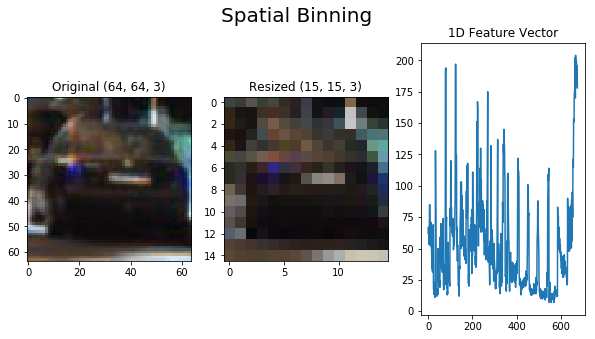

In [2]:
import visualize
%matplotlib inline
visualize.show_spatial_binning()

## Color Histogram

I made rought evaluation of color histogram size (number of bins). I used following number of bins on this rough evaluation (4, 16, 32, 64, 96) and results are in below table.

When calculating the color histogram it is important to remember that data range depends of data type and color space.
E.g RGB images have data range **0..255** and **0..1** on **uint8** and **float** datatypes respectively.



### Results with small dataset

First i evaluated larger amount of paramters with small dataset.


```
Colorspcae = LUV
HOG Orientation Bins = 9
HOG Pixels per cell = 16, 16
HOG cells per block = 4, 4
HOG channels = (0, 1, 2)
spatial size = (17,17)
hog_feat=True
hist_feat=True
spatial_Feat=True
Classifier: Linear SVM, C=50
Training samples: 1160
Test samples: 1161
```


| Rank | Tot. Test Time | Time / Sample | Score  | Vector Length | Hist Channels | Hist. Bins | 
|------|----------------|---------------|--------|---------------|---------------|------------| 
| 1    | 0.463          | 398.55E-06    | 0.9922 | 2067          | (0, 1, 2)     | 256        | 
| 2    | 0.431          | 371.18E-06    | 0.9911 | 1811          | (0, 1)        | 256        | 
| 3    | 0.411          | 354.13E-06    | 0.9911 | 1887          | (0, 1, 2)     | 196        | 
| 4    | 0.393          | 338.37E-06    | 0.9908 | 1749          | (0, 1, 2)     | 150        | 
| 5    | 0.403          | 346.86E-06    | 0.9905 | 1691          | (0, 1)        | 196        | 
| 6    | 0.425          | 366.28E-06    | 0.9905 | 1811          | (0, 2)        | 256        | 
| 7    | 0.385          | 331.81E-06    | 0.9902 | 1599          | (0, 1)        | 150        | 
| 8    | 0.366          | 315.08E-06    | 0.9902 | 1587          | (0, 1, 2)     | 96         | 
| 9    | 0.405          | 349.00E-06    | 0.9902 | 1683          | (0, 1, 2)     | 128        | 
| 10   | 0.403          | 347.51E-06    | 0.9900 | 1691          | (0, 2)        | 196        | 
| 11   | 0.336          | 289.35E-06    | 0.9900 | 1491          | (1, 2)        | 96         | 
| 12   | 0.363          | 313.03E-06    | 0.9900 | 1555          | (1, 2)        | 128        | 
| 13   | 0.360          | 310.50E-06    | 0.9900 | 1599          | (1, 2)        | 150        | 
| 14   | 0.372          | 320.41E-06    | 0.9897 | 1555          | (2,)          | 256        | 
| 15   | 0.379          | 326.87E-06    | 0.9897 | 1555          | (0, 2)        | 128        | 
| 16   | 0.387          | 333.57E-06    | 0.9897 | 1599          | (0, 2)        | 150        | 
| 17   | 0.383          | 329.84E-06    | 0.9897 | 1691          | (1, 2)        | 196        | 
| 18   | 0.409          | 351.98E-06    | 0.9897 | 1811          | (1, 2)        | 256        | 


### Results with large dataset

When i know the region which gives best results i switched to large dataset to get more accurate results

```
HOG Orientation Bins = 6
HOG Pixels per cell = 16, 16
HOG cells per block = 4, 4
HOG channels = (0, 1, 2)
spatial size = (17,17)
hog_feat=True
hist_feat=True
spatial_Feat=True
Classifier: Linear SVM, C=50
Training samples: 8880 
Test samples: 8880
```
| Rank | Tot. Test Time  | Time / Sample | Score  | Vector Length | Hist Channels | Hist. Bins | 
|------|-----------------|---------------|--------|---------------|---------------|------------| 
| 1    | 13.78           | 1.55E-03      | 0.9814 | 2067          | (0, 1, 2)     | 256        | 
| 2    | 12.11           | 1.36E-03      | 0.9811 | 1887          | (0, 1, 2)     | 196        | 
| 3    | 11.69           | 1.32E-03      | 0.9810 | 1811          | (0, 2)        | 256        | 
| 4    | 11.09           | 1.25E-03      | 0.9808 | 1749          | (0, 1, 2)     | 150        | 
| 5    | 9.64            | 1.09E-03      | 0.9806 | 1599          | (0, 2)        | 150        | 
| 6    | 10.41           | 1.17E-03      | 0.9801 | 1691          | (0, 2)        | 196        | 
| 7    | 9.52            | 1.07E-03      | 0.9798 | 1587          | (0, 1, 2)     | 96         | 
| 8    | 11.09           | 1.25E-03      | 0.9797 | 1691          | (0, 1)        | 196        | 
| 9    | 9.18            | 1.03E-03      | 0.9794 | 1491          | (0, 2)        | 96         | 
| 10   | 12.50           | 1.41E-03      | 0.9792 | 1811          | (0, 1)        | 256        | 
| 11   | 9.97            | 1.12E-03      | 0.9785 | 1599          | (0, 1)        | 150        | 
| 12   | 9.80            | 1.10E-03      | 0.9779 | 1491          | (0, 1)        | 96         | 
| 13   | 10.31           | 1.16E-03      | 0.9773 | 1555          | (2,)          | 256        | 
| 14   | 9.41            | 1.06E-03      | 0.9761 | 1495          | (2,)          | 196        | 
| 15   | 8.89            | 1.00E-03      | 0.9756 | 1449          | (2,)          | 150        | 
| 16   | 8.39            | 944.36E-06    | 0.9738 | 1395          | (2,)          | 96         | 


Color histogram selection is again tradeoff between accuracy and speed.
Good choises could be for example 1st and 5th.

### Visualization

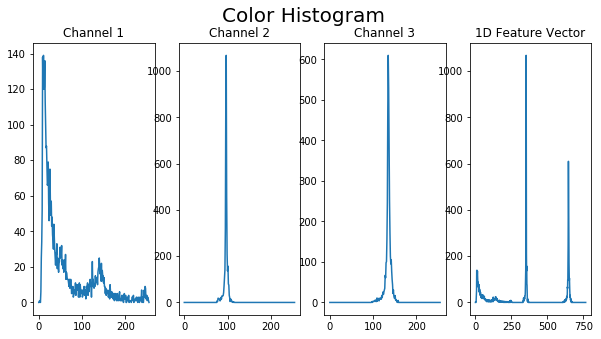

In [3]:
import visualize
%matplotlib inline
visualize.show_color_histogram()

## Histogram of Oriented Gradient

HOG have more parameters to adjust 

There are following parameters to adjust and i will do search in set of 2 parameters. If i would do search for all parameters at once it would take quite a long time. I.e if each parameter has 4 different values to test with then then there would be 256 combinations. but when searching 2 parameters at a time i can limit maximum combinations to 32.

Following parameters are tuned for HOG

- orient
- pix_per_cell
- cell_per_block
- hog_channel

### Results with small dataset

Here are results for coarce results with small dataset

```
Colorspcae = LUV
spatial size = (17,17)
Color Histogram Channels = (0, 1, 2)
Color Histogram Bins = 256
hog_feat=True
hist_feat=True
spatial_Feat=True
Classifier: Linear SVM, C=50
Training samples: 1160
Test samples: 1161
```


| Rank | Tot. Test Time | Time / Sample | Score  | Vector Length  | HOG Orient Bins | HOG Pix/Cell | HOG Cell/Block | HOG Channel | 
|------|----------------|---------------|--------|----------------|-----------------|--------------|----------------|-------------| 
| 1    | 0.875          | 753.45E-06    | 0.9934 | 3363           | 12              | (10, 10)     | (3, 3)         | (2,)        | 
| 2    | 0.578          | 498.01E-06    | 0.9934 | 2211           | 16              | (10, 10)     | (6, 6)         | (2,)        | 
| 3    | 0.627          | 539.95E-06    | 0.9931 | 2607           | 12              | (12, 12)     | (3, 3)         | (1,)        | 
| 4    | 0.730          | 628.48E-06    | 0.9928 | 2931           | 16              | (12, 12)     | (3, 3)         | (1,)        | 
| 5    | 0.565          | 486.70E-06    | 0.9928 | 2403           | 6               | (12, 12)     | (4, 4)         | (0, 1)      | 
| 6    | 0.526          | 452.85E-06    | 0.9928 | 2067           | 12              | (10, 10)     | (6, 6)         | (2,)        | 
| 7    | 0.460          | 396.12E-06    | 0.9928 | 2067           | 12              | (16, 16)     | (3, 3)         | (1,)        | 
| 8    | 0.457          | 393.64E-06    | 0.9928 | 1959           | 9               | (10, 10)     | (6, 6)         | (1,)        | 
| 9    | 1.828          | 1.57E-03      | 0.9925 | 7467           | 9               | (8, 8)       | (3, 3)         | (0, 1)      | 
| 10   | 0.986          | 849.40E-06    | 0.9925 | 3939           | 16              | (10, 10)     | (3, 3)         | (1,)        | 
| 11   | 0.683          | 588.13E-06    | 0.9925 | 2931           | 9               | (10, 10)     | (3, 3)         | (2,)        | 
| 12   | 0.459          | 395.69E-06    | 0.9925 | 2067           | 12              | (16, 16)     | (3, 3)         | (2,)        | 
| 13   | 0.435          | 374.88E-06    | 0.9925 | 1923           | 9               | (16, 16)     | (4, 4)         | (1, 2)      | 
| 14   | 1.762          | 1.52E-03      | 0.9922 | 6243           | 16              | (10, 10)     | (3, 3)         | (0, 2)      | 
| 15   | 1.409          | 1.21E-03      | 0.9922 | 5555           | 5               | (6, 6)       | (4, 4)         | (1,)        | 
| 16   | 1.394          | 1.20E-03      | 0.9922 | 5091           | 12              | (10, 10)     | (3, 3)         | (1, 2)      | 
| 17   | 1.311          | 1.13E-03      | 0.9922 | 5523           | 6               | (8, 8)       | (3, 3)         | (0, 1)      | 
| 18   | 1.197          | 1.03E-03      | 0.9922 | 4771           | 4               | (6, 6)       | (4, 4)         | (0,)        | 
| 19   | 1.012          | 871.89E-06    | 0.9922 | 4515           | 5               | (6, 6)       | (3, 3)         | (0,)        | 
| 20   | 0.845          | 728.00E-06    | 0.9922 | 3363           | 12              | (10, 10)     | (3, 3)         | (0,)        | 


Selecting right feature is again not easy task as we need to compromise between speed and accuracy. From this list good picks could be 2nd and 7th for further study. 2nd have same scores than 1st, but shorter test time.
7th provides still good accuracy and good speed.


### Results with large dataset

Here are resuls with larger dataset with reduced amount of parameters.

```
Colorspcae = LUV
spatial size = (17,17)
Color Histogram Channels = (0, 1, 2)
Color Histogram Bins = 256
hog_feat=True
hist_feat=True
spatial_Feat=True
Classifier: Linear SVM, C=50
Training samples: 8880
Test samples: 8880
```

| Rank | Tot. Test Time | Time / Sample  | Score  | Vector Length | HOG Orient Bins | HOG Pix/Cell | HOG Cell/Block | HOG Channel | 
|------|----------------|----------------|--------|---------------|-----------------|--------------|----------------|-------------| 
| 1    | 22.78          | 2.57E-03       | 0.9855 | 2931          | 16              | (12, 12)     | (3, 3)         | (1,)        | 
| 2    | 17.34          | 1.95E-03       | 0.9848 | 2211          | 16              | (16, 16)     | (3, 3)         | (1,)        | 
| 3    | 20.30          | 2.29E-03       | 0.9847 | 2607          | 12              | (12, 12)     | (3, 3)         | (1,)        | 
| 4    | 14.22          | 1.60E-03       | 0.9845 | 2067          | 12              | (16, 16)     | (3, 3)         | (1,)        | 
| 5    | 23.10          | 2.60E-03       | 0.9837 | 2931          | 16              | (12, 12)     | (3, 3)         | (2,)        | 
| 6    | 15.86          | 1.79E-03       | 0.9836 | 2211          | 16              | (16, 16)     | (3, 3)         | (2,)        | 
| 7    | 21.32          | 2.40E-03       | 0.9835 | 2659          | 16              | (12, 12)     | (4, 4)         | (1,)        | 
| 8    | 20.65          | 2.33E-03       | 0.9835 | 2607          | 12              | (12, 12)     | (3, 3)         | (2,)        | 
| 9    | 21.92          | 2.47E-03       | 0.9831 | 2659          | 16              | (12, 12)     | (4, 4)         | (2,)        | 
| 10   | 14.81          | 1.67E-03       | 0.9830 | 2067          | 12              | (16, 16)     | (3, 3)         | (2,)        | 
| 11   | 17.88          | 2.01E-03       | 0.9828 | 2403          | 12              | (12, 12)     | (4, 4)         | (1,)        | 
| 12   | 18.78          | 2.12E-03       | 0.9828 | 2403          | 12              | (12, 12)     | (4, 4)         | (2,)        | 
| 13   | 15.49          | 1.74E-03       | 0.9827 | 1891          | 16              | (16, 16)     | (4, 4)         | (1,)        | 
| 14   | 12.95          | 1.46E-03       | 0.9827 | 1827          | 12              | (16, 16)     | (4, 4)         | (1,)        | 
| 15   | 15.29          | 1.72E-03       | 0.9826 | 1891          | 16              | (16, 16)     | (4, 4)         | (2,)        | 



Good choises to go are almost any of above choices, but i select the 4th one as it is fastest and still provides quite good accuracy.

### Visualization

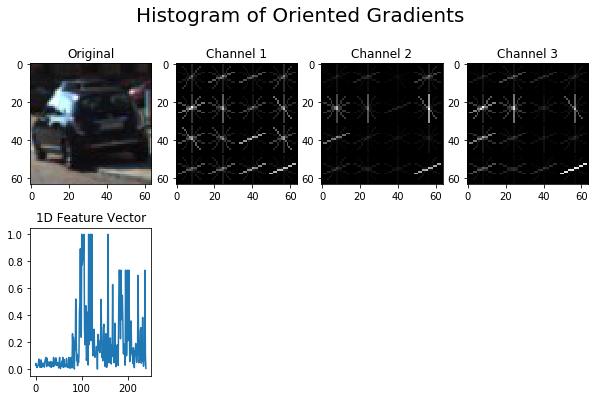

In [4]:
import visualize
%matplotlib inline
visualize.show_hog_features()

## Final Feature Selection

I will run search once more with more optimized parameter set. As it seems that one iteration takes roughly 20 seconds and i have 10 hours computer time i could search for 1800 combinations.

So let's think which paramters i should select for search.
Earlier study about individual parameters lead to following conclusion of final feature search.

- Color spaces: YUV, LUV, YCrCb
- Spatial Binning: (15,15), (16,16), (17,17)
- Color Histogram: 256
- Orient: 5,6,7
- HOG Channel: 0, 1,2, ALL - let's select them all because we are trying other color spaces as well
- pixels / cell: 15,16,17
- cells / block: 2,3,4

Those parameters form 972 different combinations and it will take few hours to find best combination.

Below are the top-11 results from the final feature selection.


| Test time | score  | Feat vect | Color space | orient | Pix/cell | Cell/block | Hog channel | Spatial size | Hist bins | Spatial feat | Hist feat | Hog feat | 
|-----------|--------|-----------|-------------|--------|----------|------------|-------------|--------------|-----------|--------------|-----------|----------| 
| 10.1E-03  | 0.9997 | 1623      | LUV         | 5      | 15       | 2          | 1           | (15, 15)     | 256       | True         | True      | True     | 
| 10.0E-03  | 0.9997 | 1983      | LUV         | 5      | 16       | 2          | ALL         | (15, 15)     | 256       | True         | True      | True     | 
| 9.6E-03   | 0.9997 | 1623      | LUV         | 5      | 16       | 3          | 1           | (15, 15)     | 256       | True         | True      | True     | 
| 9.8E-03   | 0.9997 | 1488      | LUV         | 5      | 17       | 3          | 1           | (15, 15)     | 256       | True         | True      | True     | 
| 9.7E-03   | 0.9997 | 1731      | LUV         | 6      | 16       | 4          | ALL         | (15, 15)     | 256       | True         | True      | True     | 
| 10.2E-03  | 0.9997 | 1506      | LUV         | 7      | 17       | 3          | 1           | (15, 15)     | 256       | True         | True      | True     | 
| 10.2E-03  | 0.9997 | 1983      | YCrCb       | 5      | 15       | 3          | ALL         | (15, 15)     | 256       | True         | True      | True     | 
| 10.0E-03  | 0.9997 | 1983      | YCrCb       | 5      | 16       | 3          | ALL         | (15, 15)     | 256       | True         | True      | True     | 
| 10.2E-03  | 0.9997 | 1695      | YCrCb       | 7      | 15       | 3          | 1           | (15, 15)     | 256       | True         | True      | True     | 
| 9.7E-03   | 0.9997 | 1788      | YCrCb       | 7      | 15       | 3          | 1           | (16, 16)     | 256       | True         | True      | True     | 
| 9.7E-03   | 0.9997 | 1648      | YCrCb       | 7      | 16       | 4          | 1           | (16, 16)     | 256       | True         | True      | True     | 


What is interesting is that top-11 results all have exactly same score. That raises question how could i differ these. Perhaps i need to test with more data? In searching i used minimum search values for orient=5 and pix/cell=15, cell/block=2, spatial size=(15,15). Interestingly in top performers many results had also these minumum values. Perhaps i could adjust those values more? OK. Meanwhile i focus on other things in this project i can let computer to crunch numbers and find out what are best values when i am using big data set

Top-8 results with full dataset and LUV color space

| Pos. | Tot. Test Time | Time / img | Score | Feat.Vect | Color space | Orient | Pix/Cell | Cell/Block | HOG Channel | Spatial Size | Hist Bins | 
|------|----------------|------------|-------|-----------|-------------|--------|----------|------------|-------------|--------------|-----------| 
| 1    | 20.2           | 3.80E-03   | 0.995 | 1824      | LUV         | 6      | 16       | 4          | ALL         | (16, 16)     | 256       | 
| 2    | 18.3           | 3.44E-03   | 0.995 | 1731      | LUV         | 6      | 16       | 4          | ALL         | (15, 15)     | 256       | 
| 3    | 18.5           | 3.47E-03   | 0.994 | 1776      | LUV         | 5      | 16       | 4          | ALL         | (16, 16)     | 256       | 
| 4    | 18.9           | 3.54E-03   | 0.994 | 1779      | LUV         | 7      | 16       | 4          | ALL         | (15, 15)     | 256       | 
| 5    | 20.8           | 3.91E-03   | 0.994 | 1872      | LUV         | 7      | 16       | 4          | ALL         | (16, 16)     | 256       | 
| 6    | 16.4           | 3.09E-03   | 0.994 | 1683      | LUV         | 5      | 16       | 4          | ALL         | (15, 15)     | 256       | 
| 7    | 16.5           | 3.10E-03   | 0.994 | 1632      | LUV         | 6      | 16       | 4          | 0           | (16, 16)     | 256       | 
| 8    | 19.6           | 3.68E-03   | 0.994 | 1731      | LUV         | 6      | 15       | 4          | ALL         | (15, 15)     | 256       | 



From this data we can conclude that the all of the above parameters are good and i select the 6th best because of:
- Shot test time 3ms / image
- Good score 99.39%
- Short feature vector

Final feature vector parameters.
- Color space:  LUV
- Orientation bins: 5
- Pixels / Cell: 16
- Cells/Block: 4
- HOG Channels: ALL
- Spatial binnin size: (15, 15)
- Color histogram bins: 256


# Data scaling

Scaling is important in machine learning as it make data more suitable for machine learning algorithms. Idea is that data centered around zero and have small range i.e. -1...1. 

Usually raw input data can have values on different ranges. Some features may have small values and some have big values. This leads to situation that small range will be underweighted and big range data is overweighted. Scaling solves this issue by scaling data to uniform range.

In my code Classifier class implements data scaling. it can be found in `CarFinder.classifier.Classifier()`. There are 2 important things: 1) Training of scaler is done in `fit()` method 2) Scaling itself can be done with `transform()` methdod. I'm using sklearn's StandardScaler there.


# Classifier selection

Then the next step is to find good classifier. I'm simplifying my task little bit and comparing Support Vector MAchine (SVM) with **linear** and **rbf** kernels. There are also other classifiers such like decision trees and ensemble type. It would be also good idea to use deep learning to solve this.
Anyhow i have not been playing around with SVM's much so let's give it a shot and let's see how good results we are able to get.

Again i had interesting observation. When i was using small data set the **linear** kernel was performing best, but when i switched to the full data set **rbf** kernel was performing best with 2% margin to linear kernel. I begin to focus on fine tuning rbf-kernel hyperparameters with grid search.

**C** parameter didn't have much effect, instead **gamma** parameter had remarkable effect and i found that gamma values around 0.0006 gives quite good results so in the final grid search I focused on that area.

Summary classifier final grid search results are below.

| rank | Mean test time | Mean test score | Param: C | Param: gamma | Param: kernel | 
|------|----------------|-----------------|----------|--------------|---------------| 
| 1    | 20.7           | 0.9945          | 10       | 0.0002       | rbf           | 
| 2    | 25.3           | 0.9945          | 100      | 0.0004       | rbf           | 
| 3    | 20.7           | 0.9944          | 100      | 0.0003       | rbf           | 
| 4    | 27.8           | 0.9943          | 10       | 0.0004       | rbf           | 
| 5    | 23.6           | 0.9943          | 10       | 0.0003       | rbf           | 
| 6    | 29.4           | 0.9942          | 100      | 0.0005       | rbf           | 
| 7    | 30.5           | 0.9942          | 10       | 0.0005       | rbf           | 
| 7    | 16.6           | 0.9942          | 100      | 0.0002       | rbf           | 
| 9    | 13.8           | 0.9932          | 100      | 0.0001       | rbf           | 
| 10   | 20.0           | 0.9932          | 10       | 0.0001       | rbf           | 
| 11   | 39.2           | 0.9921          | 1        | 0.0005       | rbf           | 
| 12   | 35.2           | 0.9919          | 1        | 0.0003       | rbf           | 
| 13   | 36.6           | 0.9918          | 1        | 0.0004       | rbf           | 
| 14   | 35.2           | 0.9910          | 1        | 0.0002       | rbf           | 
| 15   | 11.8           | 0.9887          | 1        |              | linear        | 
| 15   | 11.9           | 0.9887          | 10       |              | linear        | 
| 15   | 11.9           | 0.9887          | 20       |              | linear        | 
| 15   | 10.2           | 0.9887          | 50       |              | linear        | 
| 19   | 40.4           | 0.9878          | 1        | 0.0001       | rbf           | 


Selecting the right classifier seems not so trivial because top-10 scores are almost equal. What is not important that we understand the accuracy of and speed of classifiers.

It would make sense to take 3 parameter set for further studies and see how those will perform in detection pipeline.

Let's select following parameters.

- kernel: 'rbf', C: 10, gamma: 0.0002
- kernel: 'rbf', C: 100, gamma: 0.0001
- kernel: 'linear', C: 50

# Pipeline

Pipeline i'm using in this project consist of following steps.
1. Feature Generation
2. HOG-subsampling & Sliding window
3. heatmap generation
4. heatmap averaging
5. heatmap thresholding
6. Visualizing bounding box of found cars

In following sections i describe pipeline more in details.

I have appended most important visualizations to video stream generated by the `main.py` and quite accurate presentation of feature extraction can be found earlier in this document.

## Features

In my final implementation features are basically extracted in 2 different places.
1. Features class `CarFinder.features.Features()`
    - In this class i implemented spatial binning, color histogram and hog feature extraction. 
2. Hogsubsampler class `CarFinder.hogsubsampler.HogSubSampler()`
    - There is `find_cars` function which uses methods published by Features-class and also optimizes HOG-feature extraction from input image with different scales.
    
In my feature extraction code i limit datatype to **uint8** in order to simplify code. This provides known datarange 0...255 and therefore makes histogram and scaling operations simple. Drawback is worse accuracy than with float32 or float64 datatypes.

### Spatial Binning

Spatial binning is implemented in `CarFinder.features.Features()` class in `bin_spatial()` method. It's input is (64,64,3) uint8 image and output is 1D feature vector of resized image.


### Color histogram

Color histograms are calculated in `CarFinder.features.Features()` class in `color_hist()` method. It's input is uint8 image and output is uint8 1D feature vector of histograms.


### HOG

HOG features are computed in `CarFinder.features.Features()` class in `get_hog_features()` method. 


## HOG-subsampling & Sliding Window

Now this is the step which does most of the heavy lifting.
Briefly speaking it takes scene picture as an input and run sliding window search through it predicting each window whether there is car or not. Output from this is bounding box coordinates of cars.

Hog subsampling is implemented in `CarFinder.hogsubsampler.HogSubsampler()` particularly in method `find_cars()` There is one neat abstraction for it which is available by calling method `find()`.

In HOG subsampling and sliding window the overlap have been experimentally adjusted. Good value depends of other HOG parameters and i had to change the step size setting few times and try how different values work. Finally i end up to the default value 2.

Then I selected needed scaling and vertical search range by using image editing software to measure rough dimensions from test images to find out scale and most probable area where cars will be located in picture.

## Heatmap

In order to find objects reliably from scene and to avoid false positives we need way to filter results returned by hogsubsampler. In my implementation i'm using heatmaps in several ways to get improved noise rejection and stable detection.

Most of the heatmap related things are implemented in the `CarFinder.carfinder.CarFinder()` class in `find()` method. That is also the main interface to use carfinder.

### Per Frame Heatmap

For each frame i'm generating heatmap. This heatmap may include noise

### Averaged Heatmap

Averaged heatmap is good at reducing noise and false detections which only appear once here and then. I'm using `Averager` class from advanced lane detection project to calculate averaged heatmap. This provides easy to use methods to calculate **mean** and **exponential running average**
This keeps detection stable and prevents bounding box jumping back and forth.

### Heatmap Threshold

Finally heatmap is thresholded to identify cars. After thresholding heatmap is run through labeling and then finally bounding boxes are generated for cars.
Heatmap threshold is done in the method `find()` which is in `CarFinder.carfinder.CarFinder()`.




# Optimizations

First version of the car finder was working quite slowly. Approximately 1 FPS. It is clear that this is not enough for real time car detection. Let's see how could we optimize system.


## Classifier

One low hanging fruit is classifier change to Linear SVM. This would give roughly 100% speed incease. This will come with lower accuracy (>99.4vs 98.8%)

## HOG-features

HOG feature generation seems to be quite resource hungry operation so let's see if we could change HOG-channel setting. Currently i'm using all channelns to generate HOG-feature vector and if it's possible to use only one channel that would lead to big improvement.

# Discussion

This project was a quick introduction to a object tracking and detection. 

If we think about the problems of now implemented pipeline then clearly there comes two issues: 1) Speed 2) Reliability.

Unfortunately somehow i didn't get parallel processing to work with video (Note that it worked with single images and improved speed remarkably)

Reliability is issue too because current pipeline may not be able to remove all false detections. Also i noticed that in some situations there might be risk that car is not detected. Actually that risk realized during the optimization phase when classifier couldn't anymore detect black car in the video. 

Perhaps neuralnet based solution would improve car tracking pipeline?

In visualization and debugging point of view i would like to implement features which provide more information such like strength or probability of detection. 
